# Experiment 2: Acquiring time-domain IQ data 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from flux_fit import *
from utils import *

In [4]:
!python -m srsinst.dc205

## Setting up the Experiment

Setup the project and experiment names

In [ ]:
project_name = "Andreev_Spectroscopy"
device_name = "L1A"
run_id = 1
T_MXC = 29
T_Rad = None
experiment_name = f"{device_name}_trapping_measurement_RUN{run_id}_no_detuning"

drive_path = r"E:\Quasiparticles"
data_path = set_project(r"{}\{}".format(drive_path, project_name), f"{experiment_name}")

# Constants
SPATH = data_path
FIG_PATH = os.path.join(SPATH, "Figures")
LOG_FILE = os.path.join(SPATH, f'MEASUREMENTLOG_{time.strftime("%Y%m%d_%H%M%S")}.log')
PATH_TO_EXE = r'C:/Users/LFL/lflPython/AlazarDrivers/CS_Average/x64/Release/ATS9371_CS_Average.exe'

# Ensure directories exist
os.makedirs(FIG_PATH, exist_ok=True)

# Setup logging
logging.basicConfig(filename=LOG_FILE, filemode='w', level=logging.INFO)

Project path set to: E:\Quasiparticles\Andreev_Spectroscopy\040425\L1A_trapping_measurement_RUN1)_no_deturning


### Instrument Setup

Connect to the Labber server and initialize the instruments needed for the experiment

In [6]:
client = Labber.connectToServer(timeout=None)
instrument_list = client.getListOfInstruments()
instruments = create_instrument_connections(client, instrument_list)

Successfully connected to Agilent Network Analyzer E5071B
Successfully connected to Keithley 2400 SourceMeter
Successfully connected to Rohde&Schwarz RF Source
Successfully connected to SignalCore SC5511A Signal Generator_10002F25
Successfully connected to SignalCore SC5511A Signal Generator_1000334C
Successfully connected to Vaunix Lab Brick Digital Attenuator


In [7]:
vs = connect_SRS()
VNA = instruments['Agilent Network Analyzer E5071B']
DA = instruments['Vaunix Lab Brick Digital Attenuator']
SMU = instruments['Keithley 2400 SourceMeter']
LO= instruments['SignalCore SC5511A Signal Generator_10002F25']
Drive= instruments['SignalCore SC5511A Signal Generator_1000334C']
TWPA_PUMP = instruments['Rohde&Schwarz RF Source']

initialize_instruments(VNA, DA, SMU, LO, Drive, vs, TWPA_PUMP)

Make sure that the instruments are set to the correct state.

- The TWPA pump is set to the correct frequency and power
- The SRS is set to the correct voltage
- The LO is set to the correct frequency and power
- The VNA is turned off
- The Alazar is configured to acquire the correct number of traces, with the correct acquisition length, sample rate, and average time cycle.

In [8]:
set_TWPA_pump(f=6.04, power=27)

## Setting the experiment parameters

We want to bias the resonator at a certain voltage and drive it at a certain frequency.

In [9]:
flux_data = load_flux_quanta_analysis('flux_quanta_analysis.json')

Loaded flux quanta analysis with 3 periods
Period estimate: 45.00 mV


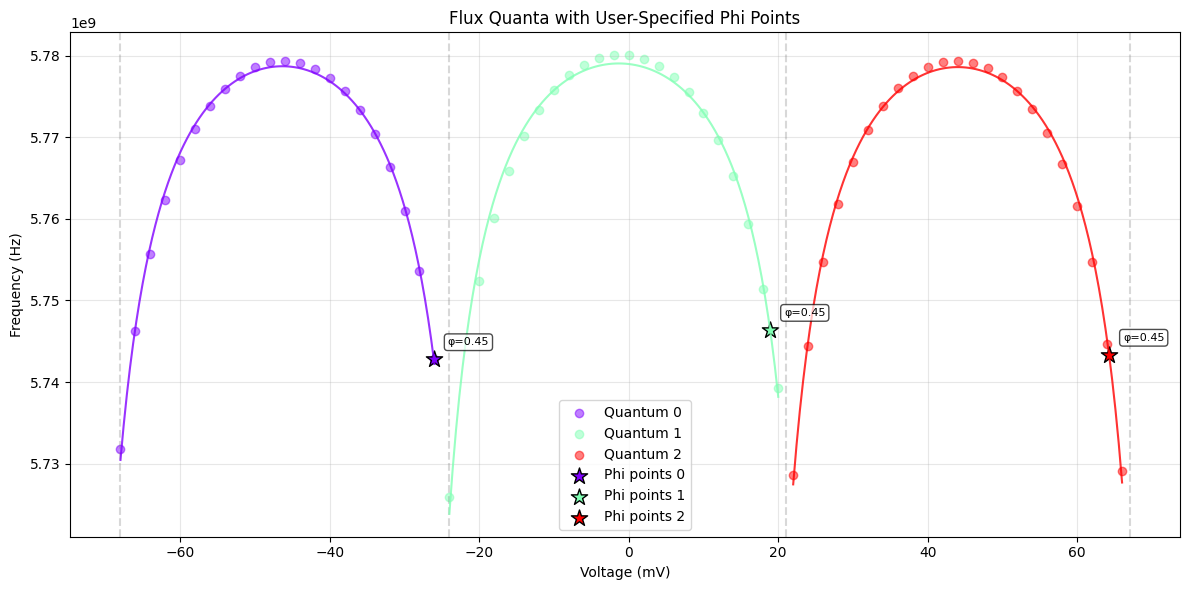


quantum_0:
  φ = 0.45 → Voltage = -26.08 mV → Frequency = 5.743e+09 Hz

quantum_1:
  φ = 0.45 → Voltage = 18.91 mV → Frequency = 5.746e+09 Hz

quantum_2:
  φ = 0.45 → Voltage = 64.26 mV → Frequency = 5.743e+09 Hz


In [10]:
# Specify phi values of interest (normalized flux)
phi_values = [0.45]  # Example phi values

phi_results = plot_phi_points(flux_data, phi_values)
guess_data = process_phi_results(phi_results)

In [11]:
phi = guess_data['quantum_1']['phi']
voltage = guess_data['quantum_1']['voltage']*1e-3 # Convert to V
guess_frequency = guess_data['quantum_1']['frequency']*1e-9 # Convert to GHz
best_fit = flux_data['quanta']['quantum_1']['best_fit']

In [12]:
import time
LABBER_LOG = r"G:\Shared drives\Labber\Data\{}\{}\Data_{}\\".format(time.strftime("%Y"), time.strftime("%m"), time.strftime("%m%d"))

lfVNA = Labber.createLogFile_ForData(os.path.join(SPATH, f'{device_name}_{project_name}_run-{run_id}_traces'),
                                      [{'name':'VNA - S21','complex':True,'vector':True,'x_name':'Frequency','x_unit':'Hz'}],
                                      step_channels=[{'name':'Phi','values':phi_values,'unit':'flux quanta'}])
initialize_logging(lfVNA, SPATH, PATH_TO_EXE, FIG_PATH, experiment_name, device_name)

Get the accurate frequency of the resonator at the desired flux point. The idea is to sweep the SRS voltage to the required voltage and take a snapshot of the VNA at the guessed frequency and update the frequency to set the LO tone

In [13]:
electrical_delay = VNA.getValue('Electrical Delay')

We have done some rough analysis and found that the QP induced frequency shift is roughly 0.5 MHz so this is what we are going to set as the detuning.


In [14]:
vna_power = 5
vna_avg = 20
span = 20e6 # Hz
detuning = 0 # Hz
f_d_power = 16

Flux-bias the resonator

In [15]:
set_flux_bias_srs(voltage, step = 5e-5)

Setting FFL bias to 18.912350483101466 mV from 18.9 mV


In [16]:
DA.setValue('Attenuation', 22)

22.0

Setting the LO and turning off the VNA

In [18]:
turn_off_LO()

f_guess: 5.746406846136997 GHz from the flux fit


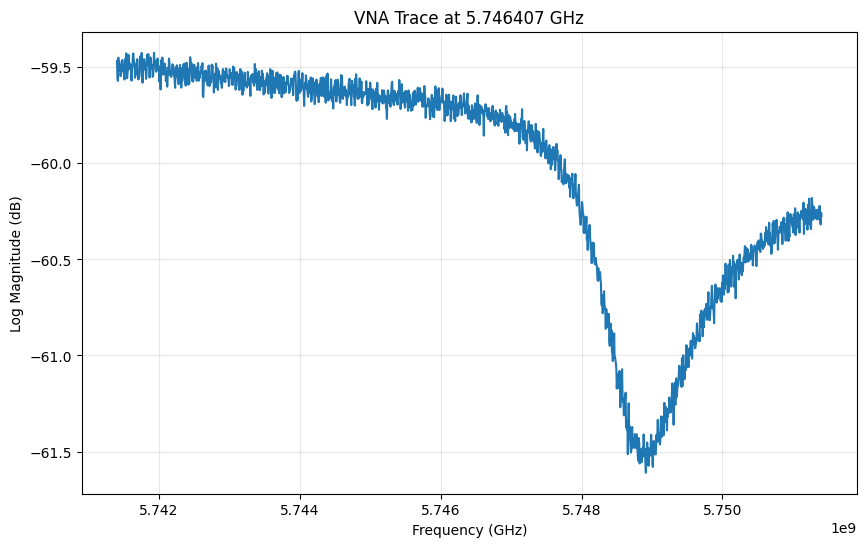

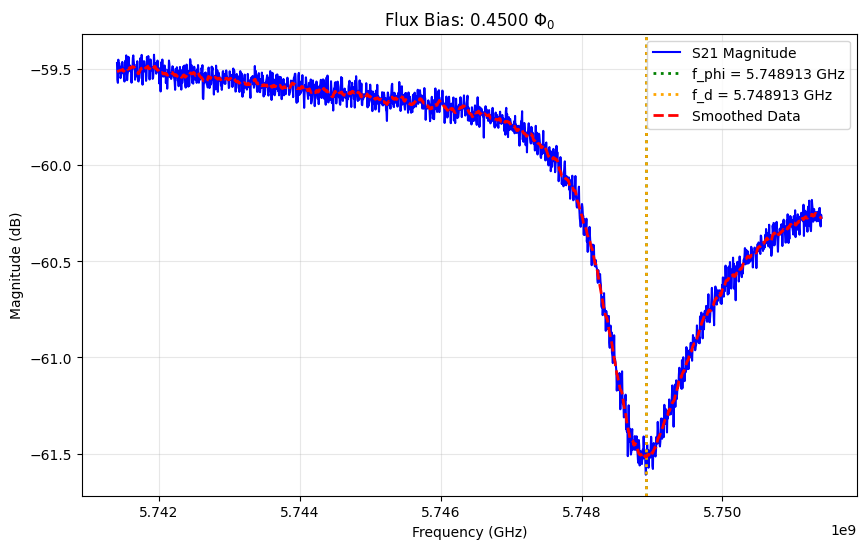

In [19]:
f_phi, f_drive = find_resonance(phi, span, best_fit, vna_power, vna_avg, electrical_delay, detuning, show_plot=True, f_guess=guess_frequency)

We are not sending in any clearing tone for this experiment.

In [20]:
f_clearing, P_clearing = None, None
turn_off_clearing()

Now set the Alazar parameters and acquire the IQ data

In [21]:
num_traces=1
acquisitionLength_sec=5
origRateMHz=300
sampleRateMHz=10
averageTimeCycle=0
lowerBound=4 # dB for DA attenuator
upperBound=30# dB for DA attenuator

In [22]:
set_LO_tone(f_drive, f_d_power)
turn_off_vna()

LO tone set to 5.748913 GHz


In [23]:
logging.info(f'\nStarting Alazar acquisition at phi = {phi:.3f} while driving at {f_drive:.6f} GHz')
metadata_files = acquire_IQ_data(phi, f_clearing, P_clearing, num_traces, acquisitionLength_sec, origRateMHz, sampleRateMHz, averageTimeCycle, lowerBound, upperBound)

# Update metadata for all files
for metadata_file in metadata_files:
    write_metadata(metadata_file, acquisitionLength_sec, origRateMHz, f_drive, voltage, T_MXC, T_Rad, phi, f_clearing, P_clearing)

100%|██████████| 14/14 [02:07<00:00,  9.09s/it]
